# Configure Phenotype Parameters

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for phenotype processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm.microplot import Microimage

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.phenotype.align_channels import align_phenotype_channels
from lib.phenotype.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)

## <font color='red'>SET PARAMETERS</font>

### Parameters for testing phenotype processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.

In [3]:
# parameters for testing
TEST_PLATE = 1
TEST_WELL = "A3"
TEST_TILE = 50
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

CHANNEL_NAMES = ["DAPI", "OMP25", "MITOTRACKER", "CONA", "DAPI2", "GRA7", "ACTUBULIN", "DAPI3", "WGA", "GM130"]
CHANNEL_CMAPS = ["pure_blue", "pure_green", "pure_red", "pure_cyan", "pure_blue", "pure_magenta", "pure_yellow", "pure_blue", "pure_cyan", "pure_green"]

# parameters for feature extraction
FOCI_CHANNEL = None

Loading test image...
Applying illumination correction...
Example corrected image:


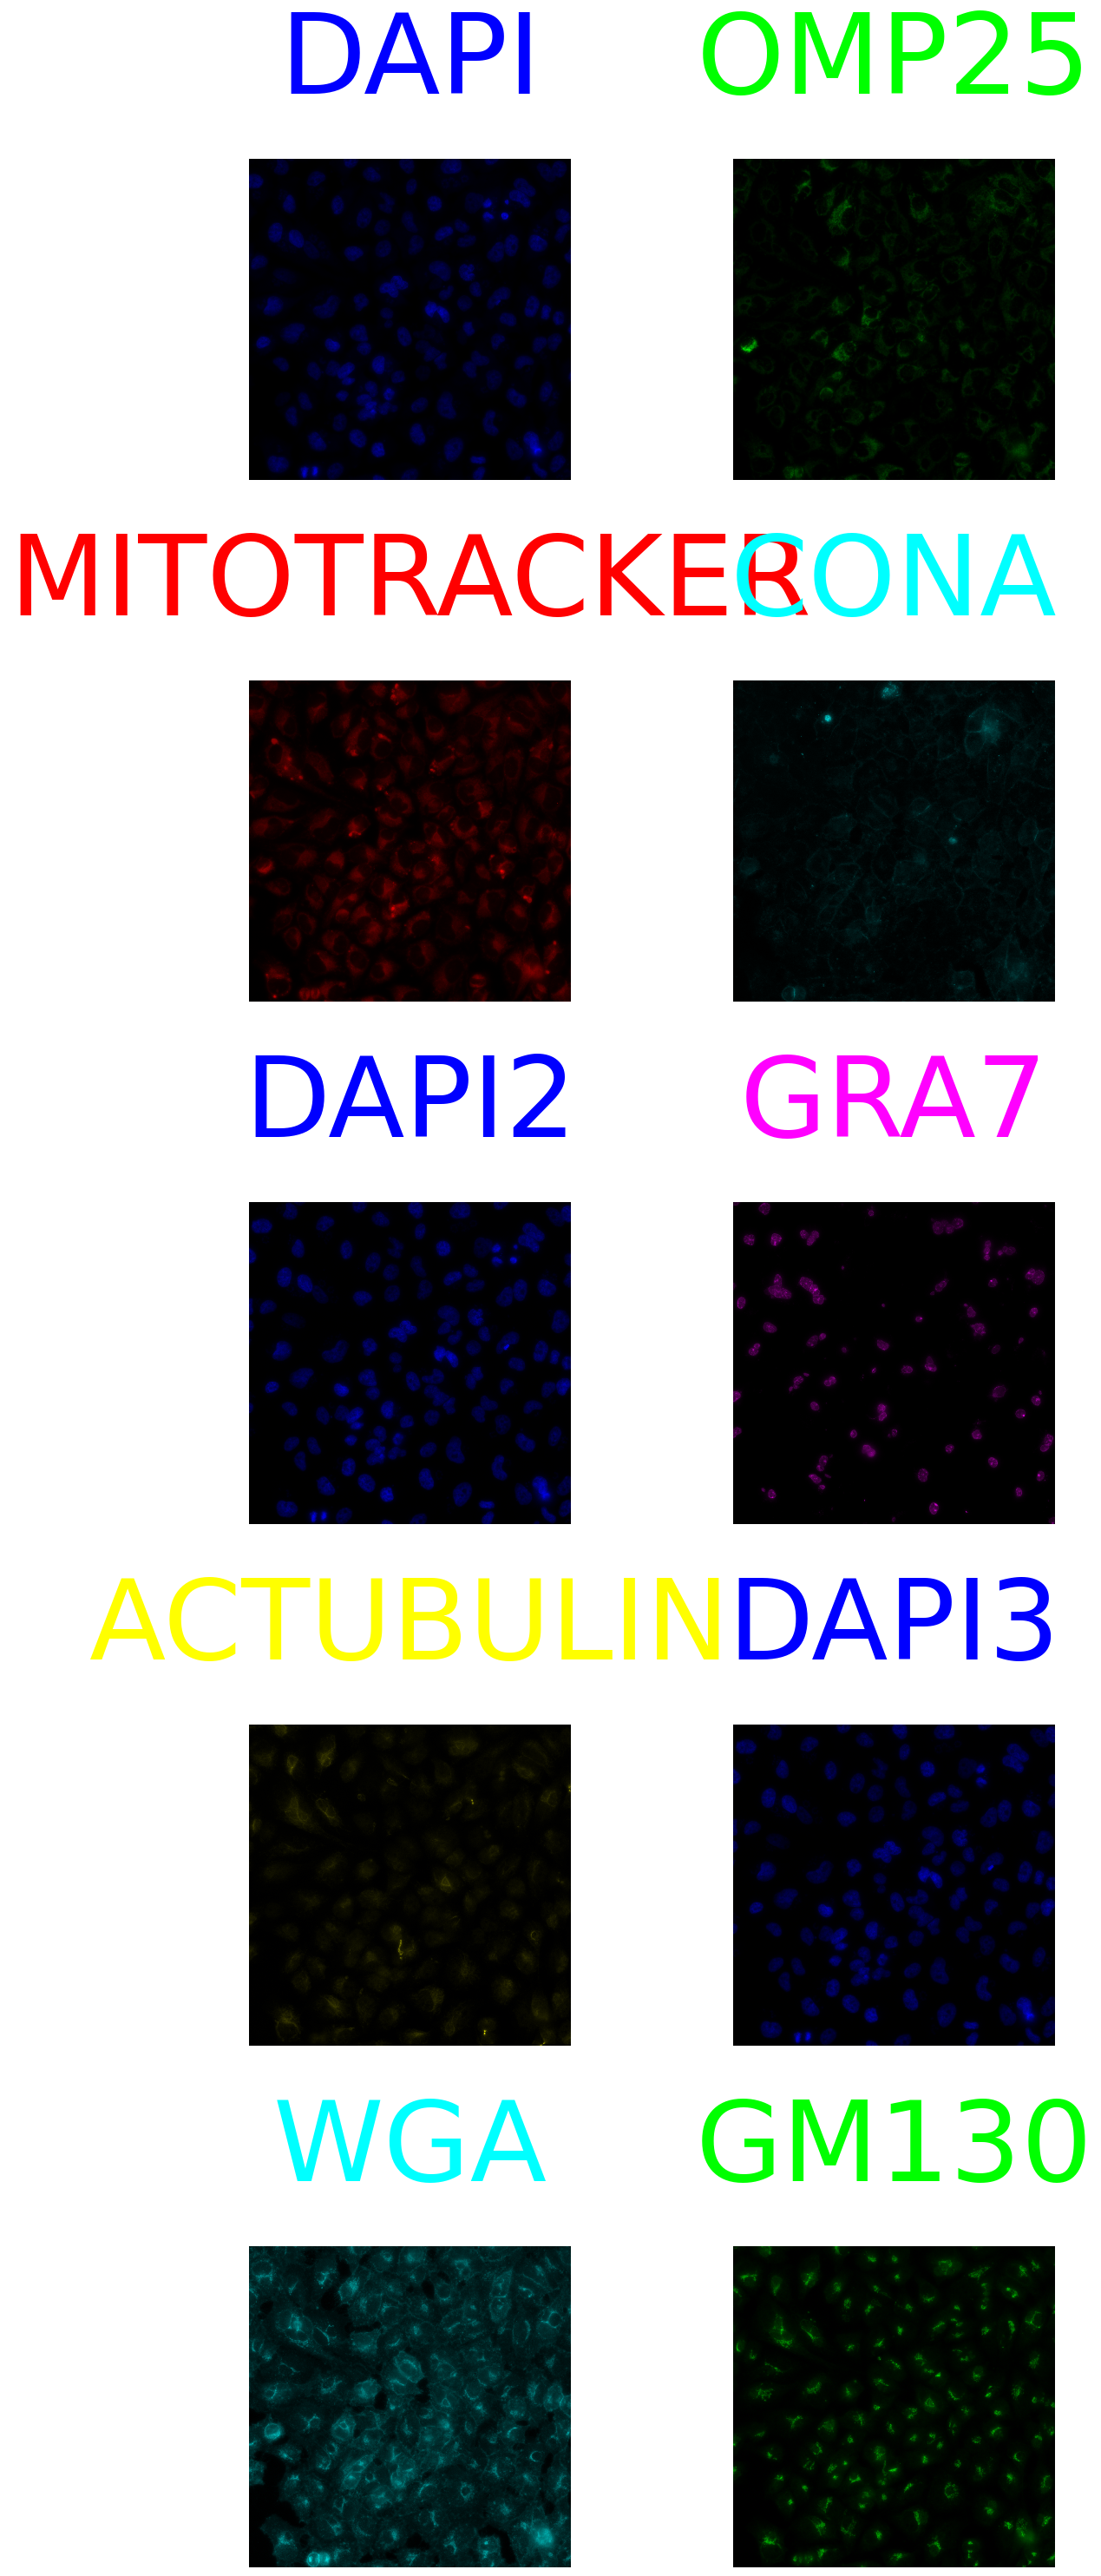

In [4]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# Create and display micropanel of corrected images
print("Example corrected image:")
corrected_microimages = [
    Microimage(
        corrected_image[i], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(corrected_image.shape[0])
]
corrected_panel = create_micropanel(corrected_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Aligning (optional)

- `ALIGN`: Whether to conduct alignment. This is suggested **unless** each image is captured with each channel consecutively. 
- `TARGET`: Index of the channel that other channels will be aligned to.
- `SOURCE`: Index of the channel to align with the target.
- `RIDERS`: Additional channel indices that should follow the same alignment as the source channel.
- `REMOVE_CHANNEL`: Specifies whether to remove channels after alignment. In the case of duplicate channels that are used to align the image, should be set to `source`.

In [5]:
# Set alignment parameters
ALIGN = True

# Define single alignment configuration for all wells with multiple steps
ALIGNMENTS = {
    1: {
        "steps": [
            # First alignment step
            {
                "target": 4,  # DAPI from second round
                "source": 7,  # DAPI3 
                "riders": [8, 9],  # Other channels in third round
                "remove_channel": "source"  # Remove DAPI3 after alignment
            },
            # Second alignment step
            {
                "target": 0,  # DAPI from first round
                "source": 4,  # DAPI2 
                "riders": [5, 6, 7, 8],  # Other channels in second round
                "remove_channel": "source",  # Remove DAPI2 after alignment
            },
        ]
    }
}

In [6]:
if ALIGN:
    print("Aligning channels...")
    # Get alignment configuration for the current plate
    plate_config = ALIGNMENTS.get(TEST_PLATE)
    
    if plate_config:
        # Start with the corrected image
        aligned_image = corrected_image
        
        # Check if this is a multi-step alignment (has "steps" key)
        if "steps" in plate_config:
            print(f"Performing multi-step alignment for plate {TEST_PLATE}...")
            
            # Apply each alignment step in sequence
            for step_num, step in enumerate(plate_config["steps"], 1):
                print(f"  Step {step_num}: Aligning {step['target']} (target) with {step['source']} (source)")
                aligned_image = align_phenotype_channels(
                    aligned_image,
                    target=step["target"],
                    source=step["source"],
                    riders=step["riders"],
                    remove_channel=step["remove_channel"],
                    upsample_factor=30,
                    window=15
                )
                CHANNEL_NAMES.pop(step["source"])
                CHANNEL_CMAPS.pop(step["source"])
        else:
            # Single-step alignment
            print(f"Performing single-step alignment for plate {TEST_PLATE}...")
            aligned_image = align_phenotype_channels(
                corrected_image,
                target=plate_config["target"],
                source=plate_config["source"],
                riders=plate_config["riders"],
                remove_channel=plate_config["remove_channel"],
            )
    else:
        # No configuration found for this plate
        print(f"Warning: No alignment configuration found for plate {TEST_PLATE}")
        aligned_image = corrected_image
else:
    aligned_image = corrected_image

Aligning channels...
Performing multi-step alignment for plate 1...
  Step 1: Aligning 4 (target) with 7 (source)
  Step 2: Aligning 0 (target) with 4 (source)


## <font color='red'>SET PARAMETERS</font>

### Segmentation

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose", "microsam", or "stardist" for cell segmentation.

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use ("cyto", "cyto2", or "cyto3"). Default is "cyto3".
- `CELL_FLOW_THRESHOLD` & `NUCLEI_FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4.
- `CELL_CELLPROB_THRESHOLD` & `NUCLEI_CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0.
- Note: Nuclei and cell diameters will be estimated automatically, but can be manually overridden.

#### MicroSAM Parameters (if using "microsam")
- `MICROSAM_MODEL`: MicroSAM model type. Default is "vit_b_lm".

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `CELL_PROB_THRESHOLD` & `NUCLEI_PROB_THRESHOLD`: Probability threshold for segmentation. Default is 0.479071.
- `CELL_NMS_THRESHOLD` & `NUCLEI_NMS_THRESHOLD`: Non-maximum suppression threshold. Default is 0.3.

#### Watershed Parameters (if using "watershed")
- `THRESHOLD_DAPI`: Threshold for nuclei segmentation. 
- `THRESHOLD_CELL`: Threshold for cell boundary segmentation.
- `NUCLEUS_AREA`: Range for filtering nuclei by area as a tuple (min, max).

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For cellpose, the nuclei and cell diameters will be automatically estimated, but can be manually adjusted if needed.

In [7]:
# Common parameters
CYTO_CHANNEL = "MITOTRACKER"
GPU = False
RECONCILE = "contained_in_cells"
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

# Select segmentation method
SEGMENTATION_METHOD = "cellpose"

if SEGMENTATION_METHOD == "cellpose":
    from lib.shared.segment_cellpose import estimate_diameters
    # Parameters for CellPose method
    CELLPOSE_MODEL = "cyto3"
    NUCLEI_FLOW_THRESHOLD = 0.4
    NUCLEI_CELLPROB_THRESHOLD = 0.0
    CELL_FLOW_THRESHOLD = 1
    CELL_CELLPROB_THRESHOLD = 0

    print("Estimating optimal cell and nuclei diameters...")
    NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        cyto_model=CELLPOSE_MODEL,
    )

elif SEGMENTATION_METHOD == "microsam":
    # Parameters for MicroSAM method
    MICROSAM_MODEL = "vit_b_lm"

elif SEGMENTATION_METHOD == "stardist":
    # Parameters for StarDist method
    STARDIST_MODEL = "2D_versatile_fluo"
    NUCLEI_PROB_THRESHOLD = 0.479071
    NUCLEI_NMS_THRESHOLD = 0.3
    CELL_PROB_THRESHOLD = 0.479071
    CELL_NMS_THRESHOLD = 0.3

Estimating optimal cell and nuclei diameters...


/lab/barcheese01/mdiberna/miniconda3/envs/brieflow_olives/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


Estimating nuclei diameters...
Estimated nuclear diameter: 115.3 pixels
Estimating cell diameters...
Estimated cell diameter: 173.3 pixels


Segmenting image with cellpose...


found 130 nuclei before removing edges
found 132 cells before removing edges


removing edges


found 113 nuclei before reconciling
found 93 cells before reconciling


reconciling masks with method how=contained_in_cells

Nuclei per cell statistics:
--------------------------
Cells with 1 nuclei: 89
Cells with 2 nuclei: 4
--------------------------



found 93 nuclei/cells after reconciling


Number of nuclei segmented: 93
Number of cells segmented: 93
Example microplots for DAPI channel and nuclei segmentation:


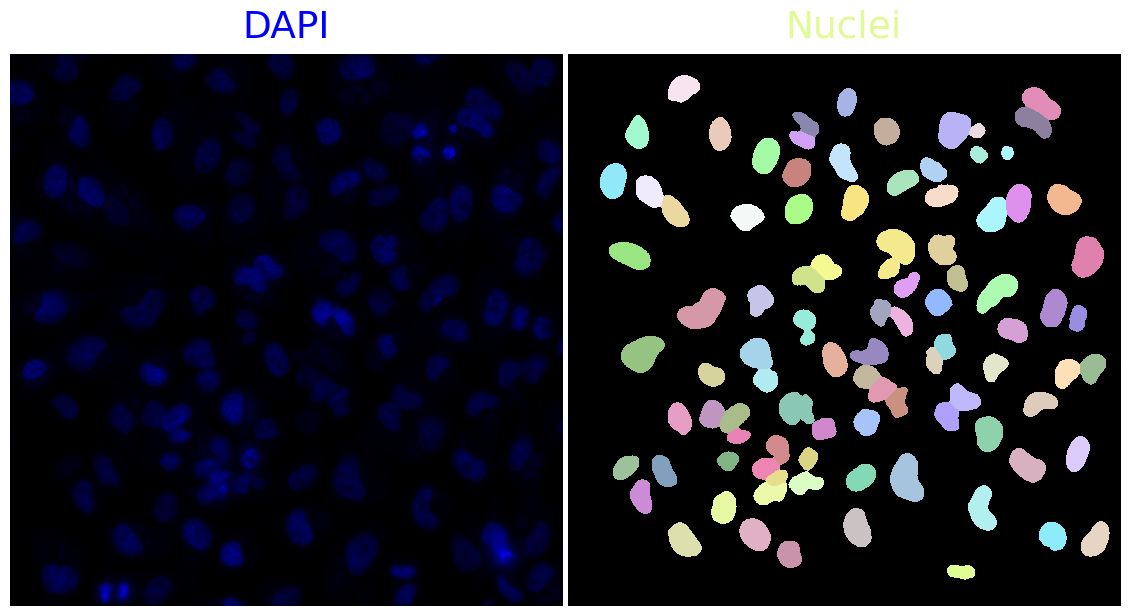

Example microplots for merged channels and cells segmentation:


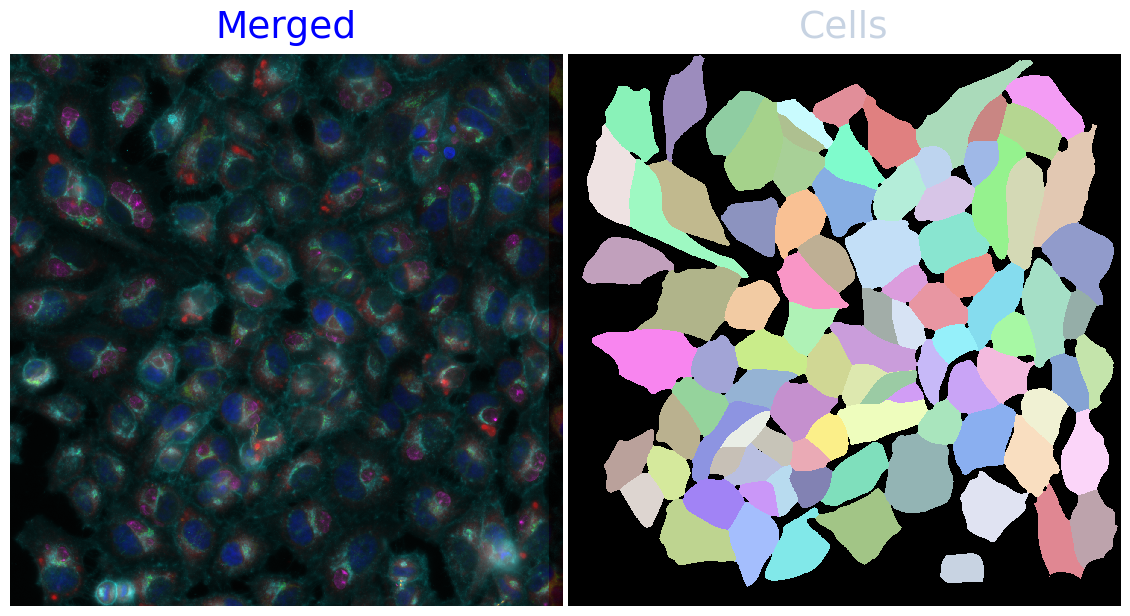

Example microplot for phenotype data annotated with segmentation:


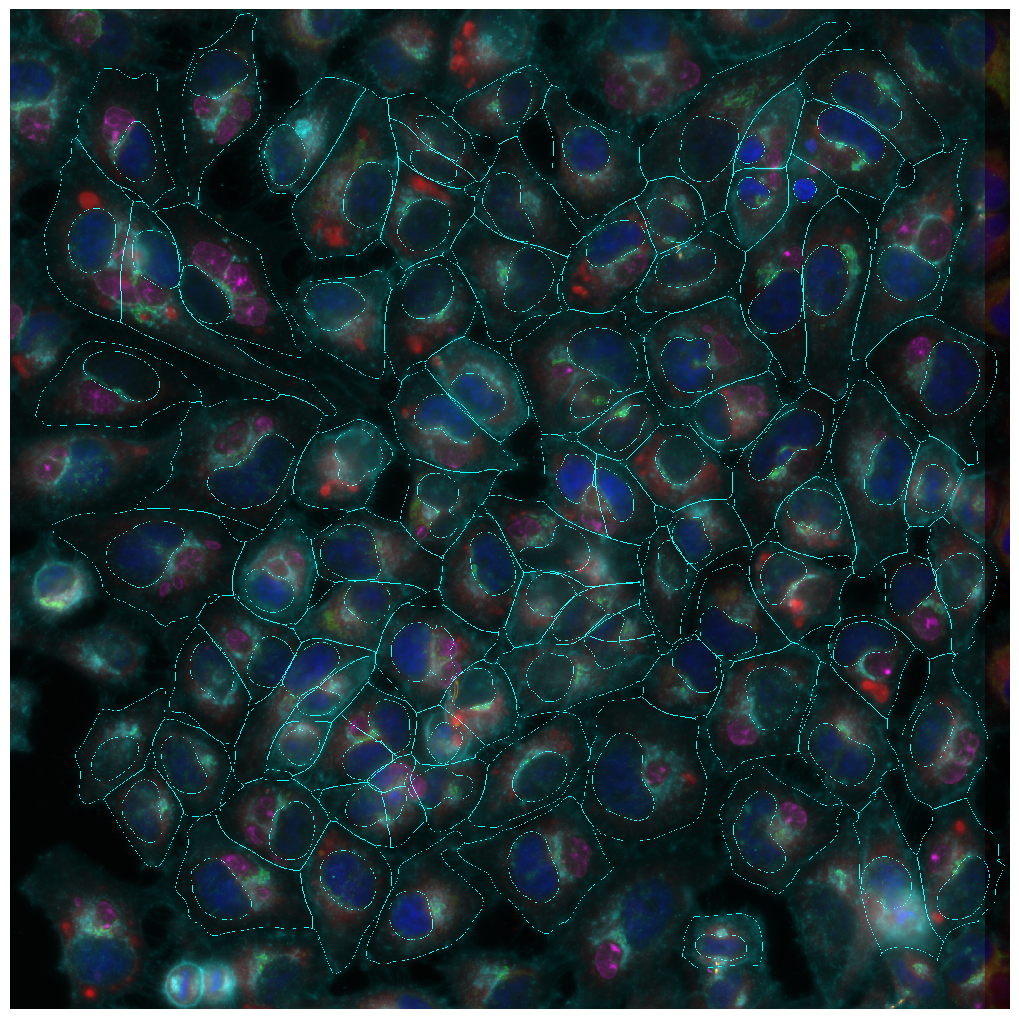

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 93


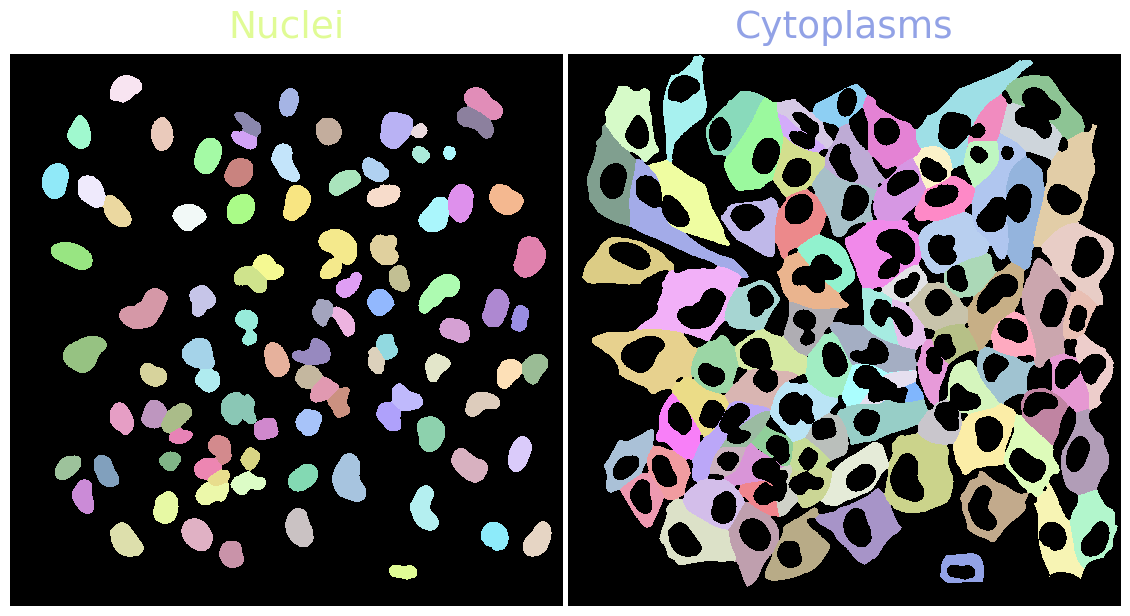

In [8]:
print(f"Segmenting image with {SEGMENTATION_METHOD}...")

if SEGMENTATION_METHOD == "cellpose":
    from lib.shared.segment_cellpose import segment_cellpose
    nuclei, cells = segment_cellpose(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cellpose_kwargs=dict(
            nuclei_flow_threshold=NUCLEI_FLOW_THRESHOLD,
            nuclei_cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
            cell_flow_threshold=CELL_FLOW_THRESHOLD,
            cell_cellprob_threshold=CELL_CELLPROB_THRESHOLD,
        ),
        cyto_model=CELLPOSE_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "microsam":
    from lib.shared.segment_microsam import segment_microsam
    nuclei, cells = segment_microsam(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=MICROSAM_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "stardist":
    from lib.shared.segment_stardist import segment_stardist
    nuclei, cells = segment_stardist(
        corrected_image,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=STARDIST_MODEL,
        stardist_kwargs=dict(
            nuclei_prob_threshold=NUCLEI_PROB_THRESHOLD,
            nuclei_nms_threshold=NUCLEI_NMS_THRESHOLD,
            cell_prob_threshold=CELL_PROB_THRESHOLD,
            cell_nms_threshold=CELL_NMS_THRESHOLD,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )

# Create and display micropanel of nuclei segmentation
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(
        aligned_image[DAPI_INDEX],
        channel_names="DAPI",
        cmaps=CHANNEL_CMAPS[DAPI_INDEX],
    ),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of segmented cells
print("Example microplots for merged channels and cells segmentation:")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_seg_microimages = [
    Microimage(
        aligned_image,
        channel_names="Merged",
        cmaps=CHANNEL_CMAPS,
    ),
    Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
]
cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of annotated phenotype data
print("Example microplot for phenotype data annotated with segmentation:")
annotated_data = image_segmentation_annotations(aligned_image, nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data, channel_names="Merged", cmaps=CHANNEL_CMAPS + ["pure_cyan"]
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

# Create and display micropanel of cytoplasms
print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasms_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasms_microimages = [
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
    Microimage(cytoplasms, cmaps=cytoplasms_cmap, channel_names="Cytoplasms"),
]
cytoplasms_panel = create_micropanel(cytoplasms_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Vacuole detection (optional)

- `VACUOLE_DETECTION`: Whether to perform vacuole detection.
- `NUCLEI_DETECTION`: Whether to perform nuclei detection within vacuoles.
- `VACUOLE_CHANNEL`: Name of the channel used for vacuole detection (typically CDPK1).
- `VACUOLE_MIN_SIZE`: Expected minimum diameter of vacuoles.
- `VACUOLE_MAX_SIZE`: Expected maximum diameter of vacuoles.
- `MIN_DISTANCE_BETWEEN_MAXIMA`: Expected minimum distance from the center of a vacuole to the center of another vacuole. Decrease if vacuoles are being split. Increase if vacuoles are being clumped together.

In [9]:
from lib.shared.extract_phenotype_minimal import extract_phenotype_minimal
from lib.phenotype.identify_vacuoles import segment_vacuoles, create_vacuole_boundary_visualization
from lib.phenotype.extract_phenotype_vacuoles import extract_phenotype_vacuoles

In [10]:
# Extract minimal phenotype data
phenotype_minimal = extract_phenotype_minimal(nuclei, nuclei, WILDCARDS)

In [ ]:
# Set vacuole parameters
VACUOLE_DETECTION = True
NUCLEI_DETECTION = False
VACUOLE_CHANNEL = "GRA7"
VACUOLE_MIN_SIZE = 10         
VACUOLE_MAX_SIZE = 200
MIN_DISTANCE_BETWEEN_MAXIMA = 5

# Derive vacuole channel index from CHANNEL_NAMES
if VACUOLE_DETECTION:
    VACUOLE_CHANNEL_INDEX = CHANNEL_NAMES.index(VACUOLE_CHANNEL)

### Test Thresholding

Thresholding using channel index 4


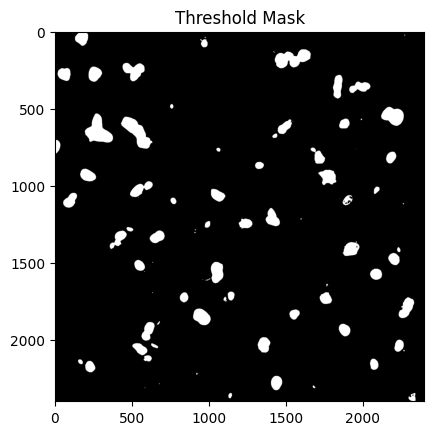

In [12]:
#Test Thresholding
import matplotlib.pyplot as plt
from skimage import filters, exposure

threshold_smoothing_scale=1.3488 # Currently hardcoded, could be a parameter
vacuole_image = aligned_image[VACUOLE_CHANNEL_INDEX]

# Apply log transform and smoothing
vacuole_log = exposure.adjust_log(vacuole_image)
vacuole_smooth = filters.gaussian(vacuole_log, sigma=threshold_smoothing_scale)

# Apply Otsu thresholding
thresh = filters.threshold_otsu(vacuole_smooth)
binary_mask = vacuole_smooth > thresh
print(f"Thresholding using channel index {VACUOLE_CHANNEL_INDEX}")
plt.imshow(binary_mask, cmap='gray')
plt.title("Threshold Mask")
plt.show()

### Test Declumping

Printing plot of declumped vacuoles...


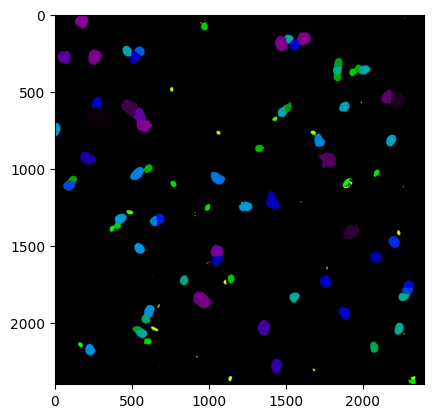

In [13]:
# Test declumping parameters
from scipy import ndimage
from skimage import feature, segmentation

# Fill holes in the binary mask
min_distance_between_maxima=MIN_DISTANCE_BETWEEN_MAXIMA 
filled_mask = ndimage.binary_fill_holes(binary_mask)

# Declumping with watershed
distance = ndimage.distance_transform_edt(filled_mask)
local_max = feature.peak_local_max(
    distance, min_distance=min_distance_between_maxima, labels=filled_mask
)

# Create markers and apply watershed
markers = np.zeros_like(filled_mask, dtype=int)
if len(local_max) > 0:
    markers[tuple(local_max.T)] = np.arange(1, len(local_max) + 1)
    declumped = segmentation.watershed(-distance, markers, mask=filled_mask)
    
    # Recover unassigned regions (label == 0) with connected component labeling
    missing = (declumped == 0) & filled_mask
    if np.any(missing):
        labeled_missing, _ = ndimage.label(missing)
        # Shift labels so they don’t overlap with watershed labels
        labeled_missing[labeled_missing > 0] += declumped.max()
        declumped += labeled_missing
else:
    declumped, _ = ndimage.label(filled_mask)

# Fill holes after declumping - OPTIMIZED: vectorized approach
unique_labels = np.unique(declumped[declumped > 0])
for label in unique_labels:
    mask = declumped == label
    filled = ndimage.binary_fill_holes(mask)
    declumped[filled] = label

# Show declumped vacuoles
print("Printing plot of declumped vacuoles...")
plt.imshow(declumped, cmap='nipy_spectral')

Printing comprehensive declumping analysis...
Visualization markers - Unique values: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136], Total pixels: 104554


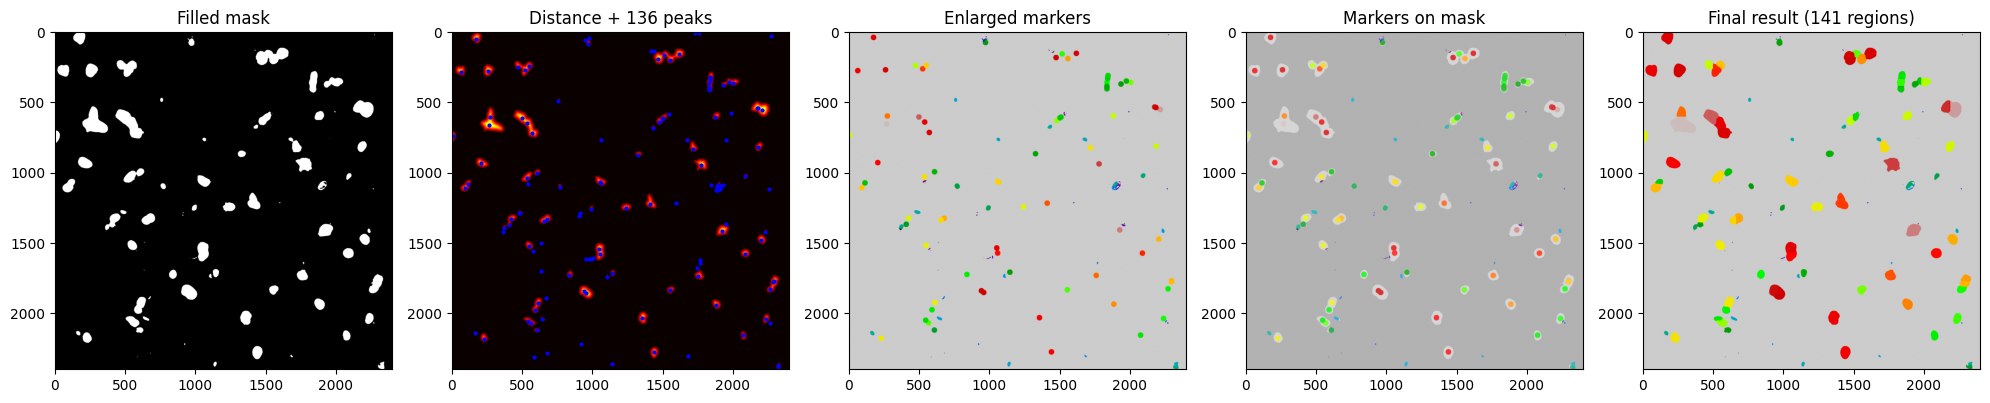

In [14]:
# Show declumped results and debugging info in one comprehensive plot
print("Printing comprehensive declumping analysis...")

# Create enlarged markers for visualization (using existing local_max)
vis_markers = np.zeros_like(filled_mask, dtype=int)
if len(local_max) > 0:
    marker_radius = 20
    for i, peak in enumerate(local_max):
        y, x = peak
        label = i + 1
        yy, xx = np.ogrid[:vis_markers.shape[0], :vis_markers.shape[1]]
        circle_mask = (yy - y)**2 + (xx - x)**2 <= marker_radius**2
        vis_markers[circle_mask & filled_mask] = label

print(f"Visualization markers - Unique values: {np.unique(vis_markers)}, Total pixels: {np.sum(vis_markers > 0)}")

# Comprehensive visualization
plt.figure(figsize=(20, 8))

plt.subplot(151)
plt.imshow(filled_mask, cmap='gray')
plt.title('Filled mask')

plt.subplot(152)
plt.imshow(distance, cmap='hot')
if len(local_max) > 0:
    plt.plot(local_max[:, 1], local_max[:, 0], 'bo', markersize=2)
plt.title(f'Distance + {len(local_max)} peaks')

plt.subplot(153)
plt.imshow(vis_markers, cmap='nipy_spectral_r')
plt.title('Enlarged markers')

plt.subplot(154)
plt.imshow(filled_mask, cmap='gray', alpha=0.7)
plt.imshow(vis_markers, cmap='nipy_spectral_r', alpha=0.8)
plt.title('Markers on mask')

plt.subplot(155)
plt.imshow(declumped, cmap='nipy_spectral_r')
plt.title(f'Final result ({len(unique_labels)} regions)')

plt.tight_layout()
plt.show()

### Test Size Filtering

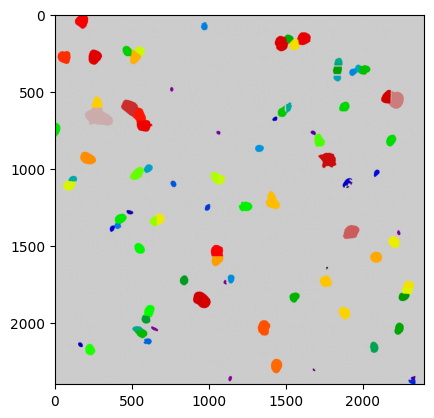

In [15]:
# Test filtering of vacuoles by size
from skimage import measure
from lib.phenotype.identify_vacuoles import get_feret_diameters

# Change these parameters if vacuoles are bing included/excluded incorrectly
min_diameter=VACUOLE_MIN_SIZE
max_diameter=VACUOLE_MAX_SIZE

# Vectorized diameter filtering
regions = measure.regionprops(declumped)
valid_labels = []

for region in regions:
    coords = region.coords[:, [1, 0]]  # Convert to (x, y) format
    if len(coords) < 3:
        pass
    else:
        feret_min, feret_max = get_feret_diameters(coords)

        if min_diameter <= feret_min and feret_max <= max_diameter:
            valid_labels.append(region.label)

# Create valid vacuoles mask efficiently
valid_vacuoles = np.isin(declumped, valid_labels) * declumped
labeled_vacuoles, num_vacuoles = ndimage.label(valid_vacuoles > 0)
# Show valid vacuoles
plt.imshow(valid_vacuoles, cmap='nipy_spectral_r')

### This test puts it all together through the defined function. If output does not match check that edits above have been propagated to function.

Segmenting vacuoles...
Performing vacuole segmentation with GRA7...
Kept 78 out of 95 detected vacuoles (82.1%)
Discarded 17 vacuoles that didn't meet diameter criteria or cell overlap
Updated cytoplasm masks by removing 78 vacuole regions
Found vacuoles in 47 out of 93 cells
Average vacuoles per cell with vacuoles: 1.66
Average vacuole area ratio: 0.0608
Example microplots for vacuole channel and vacuole segmentation:


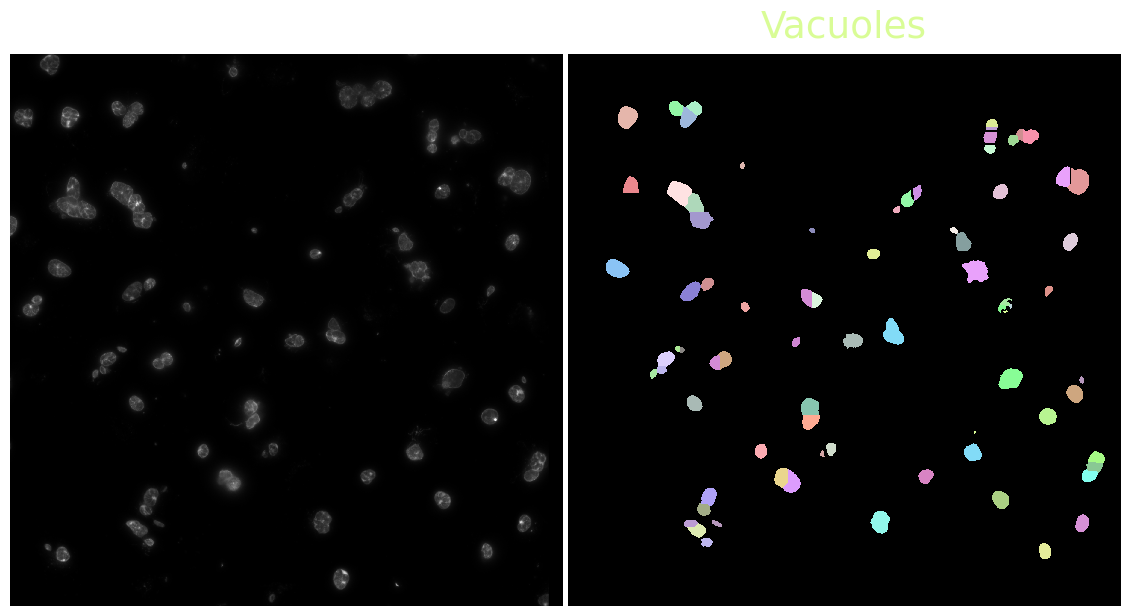

Enhanced visualization with cell boundaries, vacuole boundaries, and detected peaks:


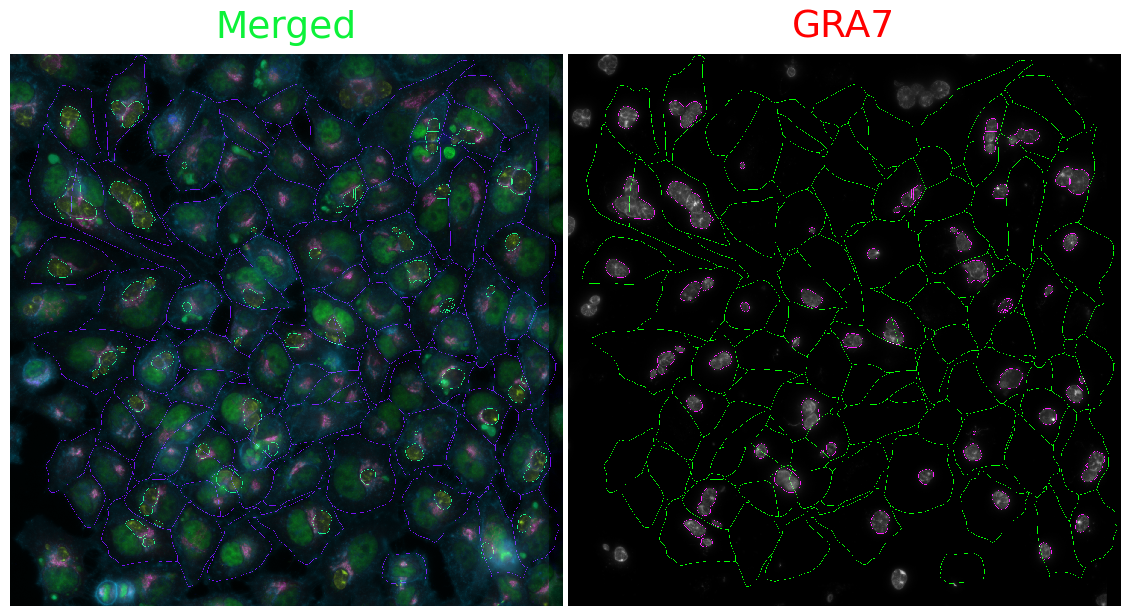

In [ ]:
print("Segmenting vacuoles...")
if VACUOLE_DETECTION:
    print(f"Performing vacuole segmentation with {VACUOLE_CHANNEL}...")
    
    vacuole_masks, cell_vacuole_table, updated_cytoplasm_masks = segment_vacuoles(
        image=aligned_image,
        vacuole_channel_index=VACUOLE_CHANNEL_INDEX,
        nuclei_channel_index=0, 
        cell_masks=cells,
        cytoplasm_masks=cytoplasms,
        vacuole_min_size=VACUOLE_MIN_SIZE,
        vacuole_max_size=VACUOLE_MAX_SIZE,
        min_distance_between_maxima=MIN_DISTANCE_BETWEEN_MAXIMA,
        nuclei_min_distance=5,
        nuclei_centroids=phenotype_minimal,
        nuclei_detection=NUCLEI_DETECTION,
    )
    cell_summary = cell_vacuole_table['cell_summary']
    vacuole_cell_mapping = cell_vacuole_table['vacuole_cell_mapping']
    
    # Print statistics
    print(f"Found vacuoles in {cell_summary['has_vacuole'].sum()} out of {len(cell_summary)} cells")
    print(f"Average vacuoles per cell with vacuoles: {cell_summary.loc[cell_summary['has_vacuole'], 'num_vacuoles'].mean():.2f}")
    print(f"Average vacuole area ratio: {cell_summary['vacuole_area_ratio'].mean():.4f}")
    
    # Create standard visualizations
    print("Example microplots for vacuole channel and vacuole segmentation:")
    vacuole_cmap = random_cmap(num_colors=len(np.unique(vacuole_masks)))
    vacuole_microimages = [
        Microimage(
            aligned_image[VACUOLE_CHANNEL_INDEX],
            channel_names=VACUOLE_CHANNEL,
            cmaps="gray",
        ),
        Microimage(vacuole_masks, cmaps=vacuole_cmap, channel_names="Vacuoles"),
    ]
    vacuole_panel = create_micropanel(vacuole_microimages, add_channel_label=True)
    plt.show()
    
    # Create enhanced boundary visualization with peaks
    print("Enhanced visualization with cell boundaries, vacuole boundaries, and detected peaks:")
    boundary_panel = create_vacuole_boundary_visualization(
        aligned_image,
        VACUOLE_CHANNEL_INDEX,
        cell_masks=cells,
        vacuole_masks=vacuole_masks,
        vacuole_cell_mapping=vacuole_cell_mapping,
        channel_names=CHANNEL_NAMES,
        show_nuclei_peaks=True
    )
    plt.show()

In [17]:
# Extract the two DataFrames from the dictionary
cell_summary_df = cell_vacuole_table['cell_summary']
vacuole_cell_mapping_df = cell_vacuole_table['vacuole_cell_mapping']

# Display the cell summary DataFrame
print("Cell Summary DataFrame:")
display(cell_summary_df)

# Display the vacuole-cell mapping DataFrame
print("\nVacuole-Cell Mapping DataFrame:")
display(vacuole_cell_mapping_df)

Cell Summary DataFrame:


cell_id  cell_area  has_vacuole  num_vacuoles   vacuole_ids  \
0         1      50698         True             3  [22, 33, 47]   
1         2      74204        False             0            []   
2         3      47336        False             0            []   
3         4      26121        False             0            []   
4         5      50529         True             1          [10]   
..      ...        ...          ...           ...           ...   
88       89      47506         True             1          [53]   
89       90      58909         True             3  [50, 60, 72]   
90       91      49557        False             0            []   
91       92      50441        False             0            []   
92       93      21737        False             0            []   

    total_vacuole_area  vacuole_area_ratio  mean_vacuole_diameter  \
0              10356.0            0.204268              65.929488   
1                  0.0            0.000000                    NaN   
2                  0.0            0.000000                    NaN   
3                  0.0            0.000000                    NaN   
4               6410.0            0.126858              90.340830   
..                 ...                 ...                    ...   
88              3612.0            0.076033              67.815494   
89              6372.0            0.108167              51.354426   
90                 0.0            0.000000                    NaN   
91                 0.0            0.000000                    NaN   
92                 0.0            0.000000                    NaN   

    mean_distance_to_nucleus  
0                 106.801682  
1                        NaN  
2                        NaN  
3                        NaN  
4                  82.336500  
..                       ...  
88                 93.527770  
89                 84.644234  
90                       NaN  
91                       NaN  
92                       NaN  

[93 rows x 9 columns]


Vacuole-Cell Mapping DataFrame:


vacuole_id  vacuole_area  vacuole_diameter  distance_to_nucleus  \
0            1       15123.0        138.763113            98.437100   
1            2        7992.0        100.874826           102.571591   
2            3        7253.0         96.097900            88.307209   
3            4        7770.0         99.463919            86.805382   
4            5        7971.0        100.742208            88.298723   
..         ...           ...               ...                  ...   
73          90         808.0         32.074562            75.486832   
74          91         431.0         23.425760            64.011731   
75          92         201.0         15.997536            85.194434   
76          94         149.0         13.773623            87.158176   
77          95         123.0         12.514330            61.509994   

    nearest_nucleus_id  cell_id  overlap_ratio  
0                   21       22       0.606427  
1                   13       14       1.000000  
2                   53       54       1.000000  
3                   22       23       1.000000  
4                   33       34       1.000000  
..                 ...      ...            ...  
73                  84       85       1.000000  
74                  75       76       0.858469  
75                  35       36       1.000000  
76                  44       36       1.000000  
77                  67       68       1.000000  

[78 rows x 7 columns]

## <font color='red'>SET PARAMETERS</font>

### Feature extraction

- `CP_METHOD`: Methodology for phenotype feature extraction.  
    - `cp_multichannel`: Use emulated code from original _Feldman et. al. 2019_ to extract CellProfiler-like features.
    - `cp_measure`: Use Pythonic version of [CellProfiler](https://github.com/afermg/cp_measure) directly from Imaging Platform. Still in development, may run slowly in Jupyter notebook for testing purposes.

  #### BEFORE USING CP MEASURE
Ensure your current conda environment is set up for cp_measure when using this method. This can be done in the following manner:
1. Clone brieflow environment:

   `conda create --name brieflow_cpmeasure_env --clone brieflow_main_env`

2. Activate the environment:

    `conda activate brieflow_cpmeasure_env`

3. Install the required package:

    `pip install cp-measure`

4. Verify dependencies with `conda list` - cp_measure requires Python 3.8 or later, and the following package versions:

    - NumPy 1.24.3*
    - centrosome 1.3.0*
    
   If you have issues running cp_measure, you may need to downgrade these packages in the cloned environment.

In [18]:
CP_METHOD = "cp_multichannel"

In [19]:
print("Extracting phenotype features:")
if CP_METHOD == "cp_measure":
    from lib.phenotype.extract_phenotype_cp_measure import extract_phenotype_cp_measure
    # Extract features using cp_measure
    phenotype_cp = extract_phenotype_cp_measure(
        aligned_image,
        nuclei=nuclei,
        cells=cells,
        cytoplasms=cytoplasms,
        channel_names=CHANNEL_NAMES,
    )
else:
    from lib.phenotype.extract_phenotype_cp_multichannel import (
        extract_phenotype_cp_multichannel,
    )
    # extract phenotype CellProfiler information
    phenotype_cp = extract_phenotype_cp_multichannel(
        aligned_image,
        nuclei=nuclei,
        cells=cells,
        wildcards=WILDCARDS,
        cytoplasms=cytoplasms,
        foci_channel=FOCI_CHANNEL,
        channel_names=CHANNEL_NAMES,
    )

phenotype_cp

Extracting phenotype features:


label well  tile    nucleus_i    nucleus_j  nucleus_bounds_0  \
0       1   A3    50   153.776035   498.742465                95   
1       2   A3    50   332.088217  1674.076282               256   
2       3   A3    50   217.855829  2053.923932               149   
3       4   A3    50   213.440024  1209.903775               151   
4       5   A3    50   347.386920   302.432044               270   
..    ...  ...   ...          ...          ...               ...   
88     89   A3    50  2113.275152  2290.638741              2032   
89     90   A3    50  2116.029321   502.694654              2037   
90     91   A3    50  2089.729510   811.813504              2019   
91     92   A3    50  2175.269689   961.890696              2116   
92     93   A3    50  2250.999841  1706.808565              2220   

    nucleus_bounds_1  nucleus_bounds_2  nucleus_bounds_3       cell_i  ...  \
0                431               215               572   216.091266  ...   
1               1606               416              1750   262.762506  ...   
2               1970               292              2140   217.433264  ...   
3               1168               276              1253   229.386356  ...   
4                249               416               352   298.659146  ...   
..               ...               ...               ...          ...  ...   
88              2225              2186              2351  2061.465667  ...   
89               434              2187               580  2103.051758  ...   
90               743              2163               879  2117.508263  ...   
91               909              2235              1015  2156.103210  ...   
92              1645              2285              1768  2237.410636  ...   

    cytoplasm_zernike_9_1  cytoplasm_zernike_9_3  cytoplasm_zernike_9_5  \
0                0.115627               0.133334               0.067530   
1                0.173922               0.227061               0.173122   
2                0.140521               0.114901               0.118949   
3                0.092985               0.045980               0.048132   
4                0.051257               0.051873               0.053467   
..                    ...                    ...                    ...   
88               0.141772               0.054459               0.024067   
89               0.056234               0.023985               0.043407   
90               0.071346               0.061226               0.025853   
91               0.033252               0.077245               0.061068   
92               0.045361               0.046674               0.019527   

    cytoplasm_zernike_9_7  cytoplasm_zernike_9_9  \
0                0.089487               0.042967   
1                0.209718               0.106032   
2                0.008809               0.034708   
3                0.019291               0.015098   
4                0.048670               0.050655   
..                    ...                    ...   
88               0.069516               0.021526   
89               0.025148               0.015088   
90               0.056300               0.037607   
91               0.041078               0.018192   
92               0.007489               0.012891   

    cytoplasm_number_neighbors_1  cytoplasm_percent_touching_1  \
0                              1                      0.018807   
1                              5                      0.352918   
2                              3                      0.265006   
3                              3                      0.183594   
4                              2                      0.153709   
..                           ...                           ...   
88                             2                      0.229499   
89                             3                      0.288090   
90                             4                      0.352403   
91                             2                      0.074157  

In [20]:
print("Extracting vacuole phenotype features:")
vacuole_phenotype = extract_phenotype_vacuoles(
    aligned_image,
    vacuoles=vacuole_masks,
    vacuole_cell_mapping_df= vacuole_cell_mapping_df,
    wildcards=WILDCARDS,
    foci_channel=FOCI_CHANNEL, 
    channel_names=CHANNEL_NAMES
)

Extracting vacuole phenotype features:


In [21]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature


# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

Unique feature types:


['cell_K',
 'cell_angle_between_neighbors',
 'cell_area',
 'cell_bounds_0',
 'cell_bounds_1',
 'cell_bounds_2',
 'cell_bounds_3',
 'cell_center_mass_c',
 'cell_center_mass_r',
 'cell_centroid_c',
 'cell_centroid_r',
 'cell_compactness',
 'cell_convex_area',
 'cell_correlation',
 'cell_eccentricity',
 'cell_euler_number',
 'cell_extent',
 'cell_first_neighbor_distance',
 'cell_form_factor',
 'cell_frac_at_d_0',
 'cell_frac_at_d_1',
 'cell_frac_at_d_2',
 'cell_frac_at_d_3',
 'cell_haralick_5_0',
 'cell_haralick_5_1',
 'cell_haralick_5_10',
 'cell_haralick_5_11',
 'cell_haralick_5_12',
 'cell_haralick_5_2',
 'cell_haralick_5_3',
 'cell_haralick_5_4',
 'cell_haralick_5_5',
 'cell_haralick_5_6',
 'cell_haralick_5_7',
 'cell_haralick_5_8',
 'cell_haralick_5_9',
 'cell_hu_moments_0',
 'cell_hu_moments_1',
 'cell_hu_moments_2',
 'cell_hu_moments_3',
 'cell_hu_moments_4',
 'cell_hu_moments_5',
 'cell_hu_moments_6',
 'cell_i',
 'cell_int',
 'cell_int_edge',
 'cell_j',
 'cell_lower_quartile',
 'c

## Add phenotype process parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_phenotype_paramsearch` will systematically explore combinations of parameters for segmentation accuracy. This is not yet implemented.

In [ ]:
# Add phenotype section
config["phenotype"] = {
    "foci_channel": FOCI_CHANNEL,
    "channel_names": CHANNEL_NAMES,
    "align": ALIGN,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "segmentation_method": SEGMENTATION_METHOD,
    "reconcile": RECONCILE,
    "gpu": GPU,
    "cp_method": CP_METHOD,
    "mode": None,
}

# Add method-specific parameters based on segmentation method
if SEGMENTATION_METHOD == "cellpose":
    config["phenotype"].update({
        "nuclei_diameter": NUCLEI_DIAMETER,
        "cell_diameter": CELL_DIAMETER,
        "nuclei_flow_threshold": NUCLEI_FLOW_THRESHOLD,
        "nuclei_cellprob_threshold": NUCLEI_CELLPROB_THRESHOLD,
        "cell_flow_threshold": CELL_FLOW_THRESHOLD,
        "cell_cellprob_threshold": CELL_CELLPROB_THRESHOLD,
        "cyto_model": CELLPOSE_MODEL,
    })
elif SEGMENTATION_METHOD == "microsam":
    config["phenotype"].update({
        "microsam_model": MICROSAM_MODEL,
    })
elif SEGMENTATION_METHOD == "stardist":
    config["phenotype"].update({
        "stardist_model": STARDIST_MODEL,
        "nuclei_prob_threshold": NUCLEI_PROB_THRESHOLD,
        "nuclei_nms_threshold": NUCLEI_NMS_THRESHOLD,
        "cell_prob_threshold": CELL_PROB_THRESHOLD,
        "cell_nms_threshold": CELL_NMS_THRESHOLD,
    })

if ALIGN:
    config["phenotype"]["alignments"] = ALIGNMENTS

if VACUOLE_DETECTION:
    config["phenotype"].update({
        "vacuole_detection": VACUOLE_DETECTION,
        "vacuole_channel_index": VACUOLE_CHANNEL_INDEX,
        "vacuole_min_size": VACUOLE_MIN_SIZE,
        "max_diameter": VACUOLE_MAX_SIZE,
        "nuclei_detection": NUCLEI_DETECTION,
        "min_distance_between_maxima": MIN_DISTANCE_BETWEEN_MAXIMA,
    })

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)